In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import visualkeras
import cv2
import os

np.random.seed(42)

In [2]:
X_DATA_PATH = "./data/cropped/"
Y_DATA_PATH = "./data/resized/"

x_data_path_list = os.listdir(X_DATA_PATH)[:32 * 50]
y_data_path_list = os.listdir(Y_DATA_PATH)[:32 * 50]

X, y = list(), list()
for x_data_path in tqdm(x_data_path_list, desc=f'X data loading...'):   X.append(cv2.imread(X_DATA_PATH + x_data_path))
for y_data_path in tqdm(y_data_path_list, desc=f'Y data loading...'):   y.append(cv2.imread(Y_DATA_PATH + y_data_path))

Y data loading...: 100%|██████████| 1000/1000 [00:00<00:00, 2651.31it/s]


In [3]:
y = np.array(y)[:, :, :, 0].reshape(-1, 256, 256, 1)
y = np.array(y) / 255.0

print(f"""Dataset shape : {y.shape}""")

Dataset shape : (1000, 256, 256, 1)


In [10]:
# ResNet BottleNeck Block
def BottleNeck(input_feature, in_channels, out_channels):
    x1 = Conv2D(in_channels, (1, 1), padding='same', activation='relu')(input_feature)
    x1 = layers.BatchNormalization()(x1)
    skip_connection = x1

    x1 = Conv2D(in_channels, (3, 3), padding='same', activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)

    x1 = Conv2D(out_channels, (1, 1), padding='same', activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)

    x1 = layers.add([x1, skip_connection])
    x1 = layers.Activation('relu')(x1)

    return x1

# Import U-Net
def unet(input_size=(256, 256, 3)):
    male_input = Input(input_size)
    female_input = Input(input_size)

    # Encoder
    male_x = BottleNeck(male_input, 64, 64)
    male_x = BottleNeck(male_x, 64, 64)

    female_x = BottleNeck(female_input, 64, 64)
    female_x = BottleNeck(female_x, 64, 64)

    male_x2 = MaxPooling2D((2, 2))(male_x)
    male_x2 = BottleNeck(male_x2, 128, 128)
    male_x2 = BottleNeck(male_x2, 128, 128)

    female_x2 = MaxPooling2D((2, 2))(female_x)
    female_x2 = BottleNeck(female_x2, 128, 128)
    female_x2 = BottleNeck(female_x2, 128, 128)

    male_x3 = MaxPooling2D((2, 2))(male_x2)
    male_x3 = BottleNeck(male_x3, 256, 256)
    male_x3 = BottleNeck(male_x3, 256, 256)

    female_x3 = MaxPooling2D((2, 2))(female_x2)
    female_x3 = BottleNeck(female_x3, 256, 256)
    female_x3 = BottleNeck(female_x3, 256, 256)

    # Latent Space
    male_x4 = MaxPooling2D((2, 2))(male_x3)
    male_x4 = BottleNeck(male_x4, 512, 512)
    male_x4 = BottleNeck(male_x4, 512, 512)

    female_x4 = MaxPooling2D((2, 2))(female_x3)
    female_x4 = BottleNeck(female_x4, 512, 512)
    female_x4 = BottleNeck(female_x4, 512, 512)

    # Decoder
    changed_male_up1 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(female_x4), (male_x3)], axis=-1)
    changed_male_up1 = BottleNeck(changed_male_up1, 256, 256)
    changed_male_up1 = BottleNeck(changed_male_up1, 256, 256)

    changed_female_up1 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(male_x4), (female_x3)], axis=-1)
    changed_female_up1 = BottleNeck(changed_female_up1, 256, 256)
    changed_female_up1 = BottleNeck(changed_female_up1, 256, 256)

    changed_male_up2 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(changed_male_up1), male_x2], axis=-1)
    changed_male_up2 = BottleNeck(changed_male_up2, 128, 128)
    changed_male_up2 = BottleNeck(changed_male_up2, 128, 128)

    changed_female_up2 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(changed_female_up1), female_x2], axis=-1)
    changed_female_up2 = BottleNeck(changed_female_up2, 128, 128)
    changed_female_up2 = BottleNeck(changed_female_up2, 128, 128)

    changed_male_up3 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(changed_male_up2), male_x], axis=-1)
    changed_male_up3 = BottleNeck(changed_male_up3, 64, 64)
    changed_male_up3 = BottleNeck(changed_male_up3, 64, 64)

    changed_female_up3 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(changed_female_up2), female_x], axis=-1)
    changed_female_up3 = BottleNeck(changed_female_up3, 64, 64)
    changed_female_up3 = BottleNeck(changed_female_up3, 64, 64)

    # Output
    male_output = Conv2D(3, (1, 1), activation='relu')(changed_male_up3)
    female_output = Conv2D(3, (1, 1), activation='relu')(changed_female_up3)

    model = Model(inputs=[male_input, female_input], outputs=[male_output, female_output])

    return model

In [12]:
model = unet(input_size=(256, 256, 3))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_158 (Conv2D)         (None, 256, 256, 64)         256       ['input_7[0][0]']             
                                                                                                  
 conv2d_152 (Conv2D)         (None, 256, 256, 64)         256       ['input_6[0][0]']             
                                                                                            

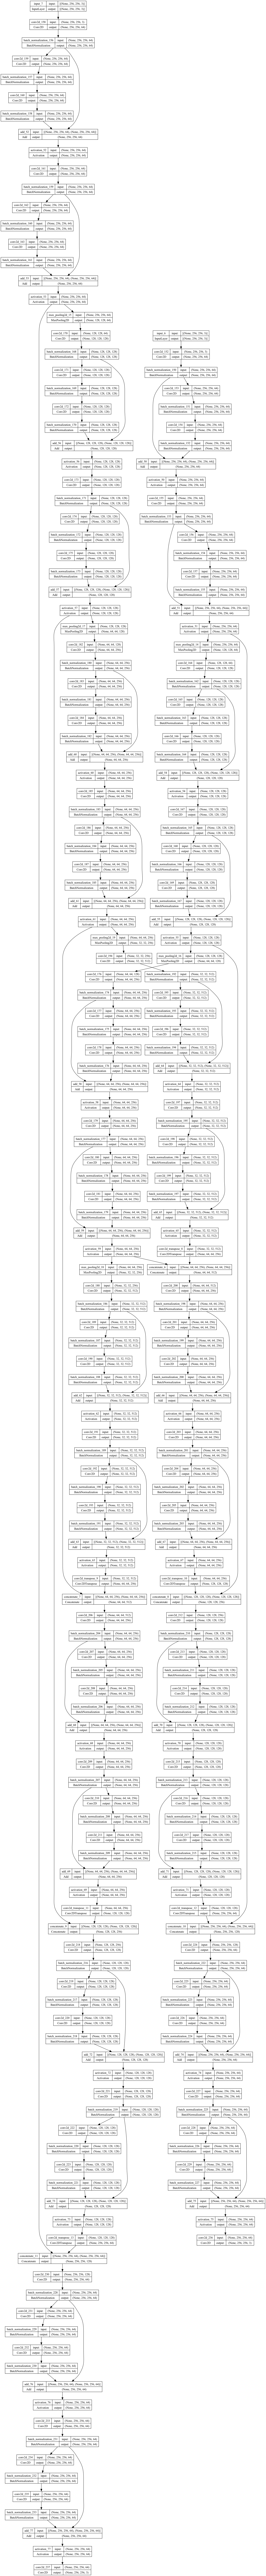

In [13]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [16]:
model = unet(input_size=(256, 256, 3))
optimizer_f = keras.optimizers.Adam(learning_rate=0.0001)
loss_f = keras.losses.MeanSquaredError()

model.compile(optimizer=optimizer_f, loss=loss_f, metrics=['accuracy', 'loss'])